In [ ]:
#|default_exp Clustering

In [ ]:
#|hide
from nbdev import *
from nbdev.showdoc import show_doc
import warnings

In [ ]:
#|export
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import kneed
import itertools
import shapely
import random
import time
import re
from CGAL.CGAL_Alpha_shape_2 import *
from CGAL.CGAL_Kernel import Point_2
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.preprocessing import StandardScaler
from shapely.geometry import LineString
from shapely.ops import polygonize
from shapely.geometry import box
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.ops import polygonize_full, linemerge, unary_union
from scipy.spatial import cKDTree, Delaunay
from graph_tool.all import triangulation, label_components
from scipy.linalg import norm
import hdbscan
import graph_tool


In [ ]:
#|export 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from HierarchicalGeoClustering.TreeClusters import TreeClusters, NodeCluster

In [ ]:
#|export
def get_alpha_shape(point_list):
    """
    Returns a polygon representing the hull of the points sample.
    
    :param list point_list: list list of tuples with samples coordinates.
    
    :returns shapely.Polygon: concave hull shapely polygon
    """
    uni_po = np.unique(point_list, axis=0)
    if len(uni_po) < 3:
        raise ValueError('Alpha Shape needs more than 3 points')
    if set_colinear(uni_po) == True:
        raise ValueError('The set of points can be colinear')

    list_of_points = [Point_2(l[0], l[1]) for l in point_list]

    a = Alpha_shape_2()

    a.make_alpha_shape(list_of_points)
    a.set_mode(REGULARIZED)
    alpha = a.find_optimal_alpha(1).next()
    a.set_alpha(alpha)

    edges = []
    for it in a.alpha_shape_edges():
        edges.append(a.segment(it))

    lines = []
    for e in edges:
        source_p = (e.source().x(), e.source().y())
        target_p = (e.target().x(), e.target().y())
        lines.append(LineString([source_p, target_p]))

    return unary_union(list(polygonize(lines)))

In [ ]:
#| export
def set_colinear(list_points):
    """
    Check if in the list of points any of triplet of points
    is colinear
    :param list list_points: List of shapely Points
    
    :returns bool: True if all are not colinear 
    """
    for i in itertools.combinations(list_points, 3):
        if collinear(i[0], i[1], i[2]) == False:
            return False
    return True

In [ ]:
#| export
def collinear(p1, p2, p3):
    """
    Check if the points are colinear 
    
    :param shapely Point p1: point to chek if is colinear
    
    :param shapely Point p2: point to chek if is colinear
    
    :param shapely Point p3: point to chek if is colinear
    
    :return bool: True if are colinear
    """
    return (p1[1]-p2[1]) * (p1[0]-p3[0]) == (p1[1]-p3[1])*(p1[0]-p2[0])

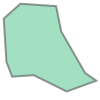

In [ ]:
#| hide
x = [random.random() for i in range(20)] 
y = [random.random() for i in range(20)] 
points_check = [i for i in zip(x,y)]
get_alpha_shape(points_check) 

In [ ]:
#| hide 
### bouth are checked
set_colinear(points_check)

False

In [ ]:
#| export
def get_segments(points):
    """ 
    Get the segments from a delaunay triangulation
    
    :param points: Point to get Delaunay triangulation and exctract points 
    
    :return edges: 
    """
    TIN = Delaunay(points)
    # list of coordinates for each edge
    edges = []
    for tr in TIN.simplices:
        for i in range(3):
            edge_idx0 = tr[i]
            edge_idx1 = tr[(i+1) % 3]
            edges.append(LineString((Point(TIN.points[edge_idx0]),
                                    Point(TIN.points[edge_idx1]))))

    return edges

In [ ]:
#|hide
lines = get_segments(points_check)

In [ ]:
#|export 
def get_polygons_buf(lines):
    """
    Obtain the poligons from the lines
    
    :param list lines: List of lines
    
    :returns shapely polygon: the union of the union of 
    edges (Polygon or multypolygon)
    """
    linework = linemerge(lines)
    linework = unary_union(linework)
    result, _, _, _ = polygonize_full(linework)
    result = unary_union(result)
    result = result.buffer(0.0000001)
    return result

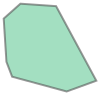

In [ ]:
#| hide
get_polygons_buf(lines)

In [ ]:
#|export 
def jaccard_distance(p1, p2):
    """
    Computes the Jaccard similarity between two polygons.
    
    param: p1 shapely Poligon 
    param: p2 shapely Poligon 
    return float Jaccard distance
    """
    intersection_area = p1.intersection(p2).area  
    #print(intersection_area)
    jacc= 1 - (intersection_area)/(p1.area + p2.area - intersection_area)
    return jacc

In [ ]:
#|hide
x = [random.random() for i in range(20)] 
y = [random.random() for i in range(20)] 
x2 = [random.random() for i in range(20)] 
y2 = [random.random() for i in range(20)] 
points_check = [i for i in zip(x,y)]
points_check2 = [i for i in zip(x2,y2)]

poly = get_alpha_shape(points_check) 
poly2= get_alpha_shape(points_check2)
jaccard_distance(poly, poly2)

0.4164714599404672

# Clustering 

In this module all the clustering methods wrap or implemented (Natural cities, DBSCAN, OPTICS, HDBSCAN, and adap_DBSCAN) all with the intention to have the same input and output. 

A recursive function is implemented to obtain the cluster iterative using the output as the new input. To select the method to use only a string is needed.


## Clustering Algorithms
A wapper functions to obtain the clusterizations 

In [ ]:
#|export
def compute_dbscan(cluster,  **kwargs):
    
    """ 
    Sklearn DBSCAN wrapper.
    
    :param cluster: a (N,2) numpy array containing the obsevations
    
    :param eps_DBSCAN: Minimal epsilon distance (Default = .04)
    
    :param debugg: To print Debugg information (Default = False)
    
    :param min_samples: Minimal salmples DBSCAN (Default= 50)
    
    :param return_noise: If True the noise is also return  (Default= True)
    
    :param scale_points: If True scale the data to [1,0]  (Default= True)
    
    :returns list with numpy arrays for all the clusters obtained
    """
    eps = kwargs.get( 'eps_DBSCAN',.04)
    debugg= kwargs.get( 'verbose',False)
    min_samples= kwargs.get( 'min_samples',50)
    ret_noise = kwargs.get('return_noise', True)
    scale_points= kwargs.get('scale_points', True)
    # Standarize sample
    scaler = StandardScaler()
    if scale_points ==True:
        if debugg:
            print('Scaling the points')
        cluster = scaler.fit_transform(cluster)
        
    
    if debugg:
        print('epsilon distance to DBSCAN: ', eps)
        print("min_samples to DBScan: ", min_samples )
        print("Number of points to fit the DBScan: ",cluster.shape[0])

    db = DBSCAN(eps=eps, min_samples=min_samples).fit(cluster)  # Check if can be run with n_jobs = -1
    
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    l_unique_labels = len(set(labels)) - (1 if -1 in labels else 0)
    unique_labels = set(labels)
    ##### returning the point to the original
    if scale_points ==True:
        if debugg:
            print('Return the points to original coordinates')
        cluster = scaler.inverse_transform(cluster)
    
    clusters = []
    #######check that not returning the same cluster 
#     if len(unique_labels) == 1 and len(cluster) == sum(labels == 0):
#         if debugg:
#             print('Its the same set of points after clustering')
#             print('Only one cluster with the same number of points \n')
#             print('Returns the points as noise')
        
#         if ret_noise == True:
#             class_member_mask = (labels == 0)
#             return clusters, points_ret[class_member_mask]
#         else:
#             return clusters # return empty cluster
    
    ########
    if debugg:
        print('Number of clusters:' ,l_unique_labels)
    
    for l in unique_labels:
        if l != -1:
            class_member_mask = (labels == l)
            clusters.append(cluster[class_member_mask])
        elif l == -1 and debugg == True:
            class_member_mask = (labels == l)
            print("Muestras consideradas ruido: ",  sum(class_member_mask))
    
    if ret_noise == True:
        class_member_mask = (labels == -1)
        return clusters, cluster[class_member_mask]
    
    return clusters

In [ ]:
#|hide
### Pruebas 
HGC = TreeClusters(4, random_seed= 124)
HGC.populate_tree(number_per_cluster=40, avoid_intersec= True)
original_points= HGC.get_points_tree()
X_2=np.array([[p.x,p.y] for p in original_points])
dic_points={'points':[X_2], 'parent':''}
res_DBSCAN_clus, noise = compute_dbscan(X_2, return_noise = True)

In [ ]:
#|eval:false
show_doc(compute_dbscan)

---

### compute_dbscan

>      compute_dbscan (cluster, **kwargs)

*Sklearn DBSCAN wrapper.

:param cluster: a (N,2) numpy array containing the obsevations

:param eps_DBSCAN: Minimal epsilon distance (Default = .04)

:param debugg: To print Debugg information (Default = False)

:param min_samples: Minimal salmples DBSCAN (Default= 50)

:param return_noise: If True the noise is also return  (Default= True)

:param scale_points: If True scale the data to [1,0]  (Default= True)

:returns list with numpy arrays for all the clusters obtained*

In [ ]:
#|export
def adaptative_DBSCAN(points2_clusters ,
                **kwargs):
    """
    The function use the knee and average to obtain a good value for epsilon and use 
    DBSCAN to obtain the clusters
    
    :param list Points points2_clusters: Point to clusterize  
    
    :param int max_k: = (Default = len(points2_clusters)*.1)
    
    :param int  min_k: (Default =50)
    
    :param int step_k: (Default = 50)
    
    :param int leaf_size: (Default = 50)
    
    :param bool scale_points: (Default = True)
    
    :param bool debugg: (Default = False)
    
    :param bool ret_noise:  (Default = True)
    
    :returns list : list of cluster. If ret_noise = True return tuple list of cluter and noise 
    """
    max_k = kwargs.get('max_k', int(len(points2_clusters)*.1))
    max_k_percent = kwargs.get('max_k_percent', None)
    min_k = kwargs.get('min_k', 50)
    step_k = kwargs.get('step_k', 50)
    leaf_size =  kwargs.get('leaf_size',50)
    scale_points= kwargs.get('scale_points',True)
    debugg = kwargs.get('verbose',False)
    ret_noise = kwargs.get('return_noise', True)
    ###### Se tienen que hacer algunos cambios para cuando
    #  los clusters son menores a los minimos establecidos previemente
    
    ##### Establecer los minimos y maximos posibles 
    if max_k > len(points2_clusters):
        raise ValueError('The max_k value is too large for the number of points')
    
    if max_k_percent != None:
        max_k = int(len(points2_clusters)*max_k_percent)
    
    if min_k >  len(points2_clusters):
        print('The min_k value is too large for the number of points returns empty clusters')
        if ret_noise == True:
            return [] , points2_clusters
        else:
            return []
    
    if step_k > len(points2_clusters):
        raise ValueError('The step_k value is too large for the number of points')

    
    if min_k == max_k:
        print('min_k reset to obtain at least 1 value')
        min_k = max_k-1

    if scale_points ==True:
        scaler = StandardScaler()
        points_arr = scaler.fit_transform(points2_clusters)
    else:
        points_arr = points2_clusters
    
    kdt=  cKDTree(points_arr, leafsize=leaf_size)
    lits_appe_all_aver=[]
    for j in range( min_k, max_k, step_k ):
        dist_va, ind = kdt.query(points_arr, k=j, workers =-1) 
        non_zero =  dist_va[:, 1:]
        non_zero = np.ndarray.flatten(non_zero)
        non_zero = np.sort(non_zero)
        lis_aver_k=[]
        for i in range(int(non_zero.shape[0]/(j-1)) -1):
            lis_aver_k.append(np.average(non_zero[i*(j-1):(i+1)*(j-1)]))

        average_arr= np.array(lis_aver_k)
        kneedle_1_average = kneed.KneeLocator(
                range(average_arr.shape[0]),
                average_arr,
                curve="convex",## This should be the case since the values are sorted 
                direction="increasing", ## This should be the case since the values are sorted incresing
                online=True, ### To find the correct knee the false returns the first find 
        )
        epsilon= kneedle_1_average.knee_y
        min_point = kneedle_1_average.knee
        #### We take the average never the less
        
        lits_appe_all_aver.append({ 'k':j,
                    'Epsilon':epsilon,
                    'value':min_point})
    
    #### Check if the list is empty
    if len(lits_appe_all_aver) ==0:
        if debugg:
            print('DBSCAN')
            print('Using 0.6 as epsilon and 20 as Minpoints')
        db_scan= DBSCAN(eps=0.6, min_samples=20).fit(points_arr)
    else:
        df_all_average= pd.DataFrame(lits_appe_all_aver)
        max_epsi_all_average= df_all_average['Epsilon'].max()
        if debugg:
            print('Valor de epsion  : ', max_epsi_all_average)
        db_scan= DBSCAN(eps=max_epsi_all_average, min_samples=min_k).fit(points_arr)
    
    ####Get the clusters
    core_samples_mask = np.zeros_like(db_scan.labels_, dtype=bool)
    core_samples_mask[db_scan.core_sample_indices_] = True
    labels = db_scan.labels_
    unique_labels = set(labels)
    if scale_points ==True:
        points_ret = scaler.inverse_transform(points_arr)
    else:
        points_ret = points_arr
    clusters = []
    #######check that not returning the same cluster 
    if len(unique_labels) == 1 and len(points2_clusters) == sum(labels == 0):
        if debugg:
            print('Only one cluster with the same number of points \n')
            print('Returns the points as noise')
        print('Its the same set of points after clustering')
        if ret_noise == True:
            class_member_mask = (labels == 0)
            return clusters, points_ret[class_member_mask]
        else:
            return clusters # return empty cluster
    
    ########
    for l in unique_labels:
        if l != -1:
            class_member_mask = (labels == l)
            clusters.append(points_ret[class_member_mask])
        elif l == -1 and debugg == True:
            class_member_mask = (labels == l)
            print("Muestras consideradas ruido: ",  sum(class_member_mask))

    if ret_noise == True:
        class_member_mask = (labels == -1)
        return clusters, points_ret[class_member_mask]

    return clusters

In [ ]:
#|hide 
### Test
HGC = TreeClusters(4, random_seed= 124)
HGC.populate_tree(number_per_cluster=40, avoid_intersec= True)
original_points= HGC.get_points_tree()
X_2=np.array([[p.x,p.y] for p in original_points])
dic_points={'points':[X_2], 'parent':''}
res_Adaptative_clus, noise = adaptative_DBSCAN(X_2, return_noise = True)

In [ ]:
#|eval:false
show_doc(adaptative_DBSCAN)

---

### adaptative_DBSCAN

>      adaptative_DBSCAN (points2_clusters, **kwargs)

*The function use the knee and average to obtain a good value for epsilon and use 
DBSCAN to obtain the clusters

:param list Points points2_clusters: Point to clusterize  

:param int max_k: = (Default = len(points2_clusters)*.1)

:param int  min_k: (Default =50)

:param int step_k: (Default = 50)

:param int leaf_size: (Default = 50)

:param bool scale_points: (Default = True)

:param bool debugg: (Default = False)

:param bool ret_noise:  (Default = True)

:returns list : list of cluster. If ret_noise = True return tuple list of cluter and noise*

In [ ]:
#|export
def compute_hdbscan(points2_clusters,  **kwargs):
    
    """
    HDBSCAN wrapper.
    
    :param np.array cluster: a (N,2) numpy array containing the obsevations
    
    :returns:  list with numpy arrays for all the clusters obtained
    """
    
    scale_points= kwargs.get('scale_points',True)
    debugg = kwargs.get('verbose',False)
    ret_noise = kwargs.get('return_noise', True)
    min_cluster = kwargs.get('min_cluster', 20)
    if scale_points ==True:
        scaler = StandardScaler()
        points_arr = scaler.fit_transform(points2_clusters)
    else:
        points_arr = points2_clusters

    db = hdbscan.HDBSCAN( ).fit(points_arr)
    core_samples_mask = np.full_like(db.labels_, True, dtype=bool)
    labels = db.labels_
    l_unique_labels = len(set(labels)) - (1 if -1 in labels else 0)
    unique_labels = set(labels)
    if debugg:
        print('total number of clusters: ', len(unique_labels)) 
    if scale_points ==True:
        points_ret = scaler.inverse_transform(points_arr)
    else:
        points_ret = points_arr
    clusters = []
    #######check that not returning the same cluster 
    if len(unique_labels) == 1 and len(points2_clusters) == sum(labels == 0):
        if debugg:
            print('Its the same set of points after clustering')
            print('Only one cluster with the same number of points \n')
            print('Returns the points as noise')
        
        if ret_noise == True:
            class_member_mask = (labels == 0)
            return clusters, points_ret[class_member_mask]
        else:
            return clusters # return empty cluster
    
    ########

    for l in unique_labels:
        if l != -1:
            class_member_mask = (labels == l)
            clusters.append(points_ret[class_member_mask])
        elif l == -1 and debugg == True:
            class_member_mask = (labels == l)
            print("Muestras consideradas ruido: ",  sum(class_member_mask))

    if ret_noise == True:
        class_member_mask = (labels == -1)
        return clusters, points_ret[class_member_mask]

    return clusters

In [ ]:
#|hide 
### Test
HGC = TreeClusters(4, random_seed= 124)
HGC.populate_tree(number_per_cluster=40, avoid_intersec= True)
original_points= HGC.get_points_tree()
X_2=np.array([[p.x,p.y] for p in original_points])
dic_points={'points':[X_2], 'parent':''}
res_HDBSCAN_clus, noise = compute_hdbscan(X_2, return_noise = True)

/home/miguel/miniconda3/envs/HCL/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/miguel/miniconda3/envs/HCL/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
show_doc(compute_hdbscan)

---

### compute_hdbscan

>      compute_hdbscan (points2_clusters, **kwargs)

*HDBSCAN wrapper.

:param np.array cluster: a (N,2) numpy array containing the obsevations

:returns:  list with numpy arrays for all the clusters obtained*

In [ ]:
#|export
def compute_OPTICS(points2_clusters,  **kwargs):
    
    """ OPTICS wrapper.
    :param np.array cluster: a (N,2) numpy array containing the obsevations
    :returns:  list with numpy arrays for all the clusters obtained
    """

    scale_points= kwargs.get('scale_points',True)
    debugg = kwargs.get('verbose',False)
    ret_noise = kwargs.get('return_noise', True)
    min_samples= kwargs.get( 'min_samples',5)
    eps_optics = kwargs.get('eps_optics', None)
    n_jobs = kwargs.get('num_jobs',None)
    xi= kwargs.get('xi',None)
    algorithm_optics= kwargs.get('algorithm_optics','kd_tree')

    if scale_points ==True:
        scaler = StandardScaler()
        points_arr = scaler.fit_transform(points2_clusters)
    else:
        points_arr = points2_clusters


    db = OPTICS(min_samples = min_samples,eps= eps_optics, n_jobs= n_jobs).fit(points2_clusters)
    core_samples_mask = np.full_like(db.labels_, True, dtype=bool)
    labels = db.labels_
    l_unique_labels = len(set(labels)) - (1 if -1 in labels else 0)
    unique_labels = set(labels)
    if debugg:
        print('total number of clusters: ', len(unique_labels)) 
    if scale_points ==True:
        points_ret = scaler.inverse_transform(points_arr)
    else:
        points_ret = points_arr
    clusters = []
    #######check that not returning the same cluster 
    if len(unique_labels) == 1 and len(points2_clusters) == sum(labels == 0):
        if debugg:
            print('Its the same set of points after clustering')
            print('Only one cluster with the same number of points \n')
            print('Returns the points as noise')
        
        if ret_noise == True:
            class_member_mask = (labels == 0)
            return clusters, points_ret[class_member_mask]
        else:
            return clusters # return empty cluster
    
    ########
    for l in unique_labels:
        if l != -1:
            class_member_mask = (labels == l)
            clusters.append(points_ret[class_member_mask])
        elif l == -1 and debugg == True:
            class_member_mask = (labels == l)
            print("Muestras consideradas ruido: ",  sum(class_member_mask))

    if ret_noise == True:
        class_member_mask = (labels == -1)
        return clusters, points_ret[class_member_mask]

    return clusters

In [ ]:
#|hide 
### Test
HGC = TreeClusters(4, random_seed= 124)
HGC.populate_tree(number_per_cluster=40, avoid_intersec= True)
original_poicompute_OPTICSnts= HGC.get_points_tree()
X_2=np.array([[p.x,p.y] for p in original_points])
dic_points={'points':[X_2], 'parent':''}
res_OPTICS_clus, noise = compute_OPTICS(X_2, return_noise = True)

In [ ]:
show_doc(compute_OPTICS)

---

### compute_OPTICS

>      compute_OPTICS (points2_clusters, **kwargs)

*OPTICS wrapper.
:param np.array cluster: a (N,2) numpy array containing the obsevations
:returns:  list with numpy arrays for all the clusters obtained*

In [ ]:
#|export 

def natural_cities_polygons(a_points, **kwargs ):
    """ Take a array of points and returns the natural Cities polygons.
        Parameters:
        a_points (Array points): points to process into natural cities .
        result_df (Polygon GeoDataframe): Single Geodataframe with the polygons that encloses the points
    """
    tail_particion = kwargs.get('tail_particion', 0.55)
    polygon= kwargs.get('polygon', None)
    debugg = kwargs.get('verbose',False)
    edges = get_segments(a_points)
    edges = {'geometry': edges}
    edges_df = gpd.GeoDataFrame(edges)
    edges_df['length'] = edges_df.geometry.length
    mean_lenght=edges_df['length'].mean()
    tail = edges_df[edges_df['length'] < mean_lenght]
    ##check if is heavi tail
    tail_percent = tail.shape[0]/edges_df.shape[0]
    if tail_percent < tail_particion:
        if debugg:
            print('The percentage of edges that are in the tail are not meet, return empy dataframes ')
        #### Returning empty dataframe
        tail = gpd.GeoDataFrame()
        result_df = gpd.GeoDataFrame()
        return (tail, result_df)
        
    
    if polygon is not None:
        # use only lines within polygon
        tail = gpd.sjoin(tail, polygon, how='inner', op='within')
    linework = linemerge( tail.geometry.to_list() )
    linework = unary_union(linework)
    result, _, _, _ = polygonize_full(linework)
    result = unary_union(result)
    if type(result ) == shapely.Polygon:
        gpd.GeoDataFrame(index=[0],geometry=[ result])
    else:
        result = {'geometry': result.geoms}
    try:
        result_df = gpd.GeoDataFrame(result)
        
    except:
        print(result)
        #print(len(result.geoms))
        print('Unable to do the dataframe return empty dataframes ')
        tail = gpd.GeoDataFrame()
        result_df = gpd.GeoDataFrame()
        return (tail, result_df)
        
        # result_df = gpd.GeoDataFrame({'geometry':[]})
    return (tail, result_df)

In [ ]:
#|export 
def compute_Natural_cities(points2_clusters, **kwargs):
    """
    Compute Natural cities clustering
    
    :param np.array points2_clusters: a (N,2) numpy array containing the obsevations
    
    :returns: list with numpy arrays for all the clusters obtained
    """
    ### The function is in acordance with the all the previus functions
    scale_points= kwargs.get('scale_points',False)
    debugg = kwargs.get('verbose',False)
    ret_noise = kwargs.get('return_noise', True)
    
    
    if scale_points ==True:
        scaler = StandardScaler()
        points_arr = scaler.fit_transform(points2_clusters)
    else:
        points_arr = points2_clusters


    polygons_df = natural_cities_polygons(points_arr, **kwargs)
    ####Handle when dataframes are empty, it could be for tail partition large enogh
    ### empty  
    if debugg:
        print('Los poligonos de Natural cities')
        print(polygons_df[1].head())
    if polygons_df[0].empty and polygons_df[1].empty:
        if debugg:
            print('Not meeting the minimun tail size')
        if ret_noise == True:
            return [], points2_clusters
        else:
            return [] # return empty cluster

    if debugg:
        print('Size of the polygons dataframe: ', polygons_df[1].shape[0])
    #### put the point in a data frame to do a spatial joint
    all_points_Point= [shapely.geometry.Point(arre[0], arre[1]) for arre in  points2_clusters]

    points_geom_df = gpd.GeoDataFrame({'geometry':all_points_Point })
    result_joint  = gpd.sjoin(points_geom_df, polygons_df[1], how='left', predicate='within')
    
    result_joint= result_joint.fillna(-1)
    result_joint['x']= result_joint['geometry'].x
    result_joint['y']= result_joint['geometry'].y
    
    #### recover
    if scale_points ==True:
        array_trans = scaler.inverse_transform(result_joint[['x', 'y']].values)
        result_joint['x_trans']=  array_trans[:,0]
        result_joint['y_trans']=  array_trans[:,1]

    else:
        result_joint['x_trans']=  result_joint['x']
        result_joint['y_trans']=  result_joint['y']
    
    if debugg:
        print('The shape of the Dataframe of points: ', result_joint.shape)
        
    
    if debugg:
        print('Number of classes of  polygons: ',len(result_joint['index_right'].unique()))
    
    
    clusters = []
    for i in result_joint['index_right'].unique():
        if i != -1:
            clusters.append(result_joint[result_joint['index_right'] == i][['x_trans','y_trans']].values)
        else:
            noise_ = result_joint[result_joint['index_right'] == i][['x_trans','y_trans']].values
    
    if ret_noise == True:
        return clusters, noise_
    
    return clusters

In [ ]:
#|hide 
### Test
HGC = TreeClusters(4, random_seed= 124)
HGC.populate_tree(number_per_cluster=40, avoid_intersec= True)
original_points= HGC.get_points_tree()
X_2=np.array([[p.x,p.y] for p in original_points])
dic_points={'points':[X_2], 'parent':''}
res_, noise = compute_Natural_cities(X_2, return_noise = True, debugg= True)

In [ ]:
show_doc(compute_Natural_cities)

---

### compute_Natural_cities

>      compute_Natural_cities (points2_clusters, **kwargs)

*Compute Natural cities clustering

:param np.array points2_clusters: a (N,2) numpy array containing the obsevations

:returns: list with numpy arrays for all the clusters obtained*

In [ ]:
#|export 
def compute_AMOEBA(points_array, **kwargs):
    """The function obtains the AMOEBA algorithm on level basis
    
    :param np.array points2_clusters: a (N,2) numpy array containing the obsevations
    
    :returns: list with numpy arrays for all the clusters obtained
    """
    
    scale_points= kwargs.get('scale_points',True)
    debugg = kwargs.get('verbose',False)
    ret_noise = kwargs.get('return_noise', True)
    min_leng_clus_AMOEBA= kwargs.get('min_lenght_cluster_AMOEBA', 3)
    if scale_points ==True:
        scaler = StandardScaler()
        points_arr = scaler.fit_transform(points_array)
    else:
        points_arr = points_array
    ########
    if len(points_arr) < min_leng_clus_AMOEBA:
        clusters=[]
        noise_level= np.empty((0,2))
        if ret_noise == True:
            return clusters, noise_level
        else:
            return clusters
    
    
    gr, pos_d =triangulation(points_arr, "delaunay")
    dis_d = gr.new_edge_property("double")
    for e in gr.edges():
        dis_d[e] =  norm(pos_d[e.target()].a - pos_d[e.source()].a)
    gr.edge_properties["dis"] = dis_d
    gr.vertex_properties["pos"] = pos_d
    global_edge_mean= np.nan_to_num(gr.edge_properties['dis'].get_array().mean())
    global_edge_std = np.nan_to_num(gr.edge_properties['dis'].get_array().std() )
    
    all_remove_level =[]
    all_keep_level = []
    for vert in gr.vertices():
        local_mean= np.mean([gr.edge_properties['dis'][vo_edge]  for vo_edge in vert.out_edges()])
        tolerance = global_edge_std * (global_edge_mean/local_mean)
        rem_edg_loc = []
        keep_edg_loc = []
        for ed in vert.all_edges():
            if gr.edge_properties['dis'][ed] > tolerance + global_edge_mean:
                rem_edg_loc.append(ed)
            else:
                keep_edg_loc.append(ed)
        all_keep_level.append(keep_edg_loc)
        all_remove_level.append(rem_edg_loc)
    
    all_remove_level_flat= []
    for _list in all_remove_level:
        all_remove_level_flat += _list
    all_keep_level_flat= []
    for _list in all_keep_level:
        all_keep_level_flat += _list
    level_n = gr.new_edge_property("bool", True)
    gr.edge_properties["level_n_tolerance"] = level_n
    
    #### Probably not needed or can be reduce
    #### The edge tolerance
    for i in all_remove_level_flat:
        gr.edge_properties['level_n_tolerance'][i]= False
    for i in all_keep_level_flat:
        gr.edge_properties['level_n_tolerance'][i]= True
        
    gr.set_edge_filter(prop =  gr.edge_properties['level_n_tolerance'])
    
    
    ##### If the vertex should be keep
    gr.vertex_properties["level_n_r"] = gr.new_vertex_property("bool", False)
    for vert in gr.vertices():
        if vert.in_degree() + vert.out_degree()> 0:
            gr.vertex_properties['level_n_r'][vert]= True
        else: 
            gr.vertex_properties['level_n_r'][vert]= False
    ##  to not consider the noise points
    gr.set_vertex_filter(prop =  gr.vertex_properties['level_n_r'])
    
    ## Get the connected components
    level_n_components_arr, comp_n_hist = label_components(gr)
    gr.set_vertex_filter(None)
    
    gr.vertex_properties["compo_level_n"] = gr.new_vertex_property("int", -1)
    
    gr.set_vertex_filter(prop =  gr.vertex_properties['level_n_r'])
    
    
    compo_level_res_n = gr.new_vertex_property("int", -1)
    compo_level_res_n.a = level_n_components_arr.a
    gr.vertex_properties["compo_level_res_n"] = compo_level_res_n
    
    for vert in gr.vertices():
        # print(num)
        if vert.in_degree() + vert.out_degree()> 0:
            gr.vertex_properties['compo_level_n'][vert]= gr.vertex_properties["compo_level_res_n"][vert] 
        else: 
            # print('No edge')
            gr.vertex_properties['compo_level_n'][vert]= -1
    
    
    ####### get the points for each cluster 
    clusters_result_n= np.nan_to_num(np.unique(gr.vertex_properties['compo_level_n'].a))
    clusters=[]
    noise_level= np.empty((0,2))
    #######check that not returning the same cluster 
    if len(clusters_result_n) == 1 and len(points_array) == sum(gr.vertex_properties['compo_level_n'].a  == 0):
        if debugg:
            print('Its the same set of points after clustering')
            print('Only one cluster with the same number of points \n')
            print('Returns the points as noise')
        
        if ret_noise == True:
            class_mask = (gr.vertex_properties['compo_level_n'].a  == 0)
            return clusters, points_array[class_mask] #Empty cluster list an all the points as noise
        else:
            return clusters # return empty cluster
    
    ########

    
    
    for clas in clusters_result_n :
        if clas != -1:
            clas_mask = ( gr.vertex_properties['compo_level_n'].a == clas)
            clusters.append(points_array[clas_mask])
        else:
            clas_mask = ( gr.vertex_properties['compo_level_n'].a == clas)
            noise_level= points_array[clas_mask]
    if ret_noise == True:
        return clusters, noise_level
    return clusters
        
    

In [ ]:
#|hide 
### Test
HGC = TreeClusters(4, random_seed= 124)
HGC.populate_tree(number_per_cluster=40, avoid_intersec= True)
original_points= HGC.get_points_tree()
X_2=np.array([[p.x,p.y] for p in original_points])
dic_points={'points':[X_2], 'parent':''}
res_AMOEBA_clus, noise = compute_AMOEBA(X_2, return_noise = True)

In [ ]:
show_doc(compute_AMOEBA)

---

### compute_AMOEBA

>      compute_AMOEBA (points_array, **kwargs)

*The function obtains the AMOEBA algorithm on level basis

:param np.array points2_clusters: a (N,2) numpy array containing the obsevations

:returns: list with numpy arrays for all the clusters obtained*

## Tree and clustering 
The following functions use the clustering functions define abobe to clasify and obtain a cluster tree structure. 

In [ ]:
#| export
def clustering(
            t_next_level_2,
            level=None,
            algorithm='dbscan',
            **kwargs
    ):
    """Function to get the clusters for single group by
    
    :param t_next_level_2: Dictionary with the points to compute the
            cluster
    :param level:  None Level to compute (Default None)
    
    :param str algorithm : Algorithm type is supported (Default= 'dbscan')
    
    :param int min_points_cluster:  minimun number of point to consider a cluster(Default 50)
    
    :param double eps: Epsilon parameter in the case that is needed (DBSCAN).
    
    :param bool return_noise: To return the noise (Default= True)
    
    :param bool verbose: Printing (Default= False)  
    
    :param algorithm_pass function: the algorithm to use if algorith = 'other',
            the algorithm has to be in acordance to return the same as 
            all other algorithms implemented. 
    
    
    :returns list t_next_level_n: A list with dictionaries with the points, 
                        the parent, and noise
    """
    verbose= kwargs.get('verbose',False)
    min_points = kwargs.get( 'min_points_cluster', 50) #### creo que se deberia quitar o poner bien
    ret_noise= kwargs.get('return_noise', True)
    eps = kwargs.get('eps',0.8)  # Epsilon value to dbscan
    algorithm_pass= kwargs.get('algorithm_pass', None)

    min_leng_clus= kwargs.get('min_lenght_cluster', 5)
    t_next_level_n = []
    if level == None:
        level = 0

    for li_num, cluster_list_D in enumerate(t_next_level_2):
        cluster_list = cluster_list_D['points']
        cluster_list_pa = cluster_list_D['parent']
        if verbose:
            print("Size cluster list: ", len(cluster_list))
            
        for c_num, cluster in enumerate(cluster_list):
            if verbose:
                print("Size cluster: ", len(cluster))
                print('Algorithm: ', algorithm)

            if len(cluster) > min_leng_clus:
                if algorithm == 'dbscan':
                    if verbose:
                        print("Epsilon Value: ", eps)
                    tmp = compute_dbscan(cluster,
                                 eps_DBSCAN = eps,
                                 debugg=verbose,
                                  **kwargs)
                    if ret_noise:
                        noise_points = tmp[1]
                        tmp =  tmp[0]
                
               
                elif algorithm == 'hdbscan':
                    tmp = compute_hdbscan(cluster,
                                **kwargs)
                    if ret_noise:
                        noise_points = tmp[1]
                        tmp =  tmp[0]
                ##########  
                elif algorithm == 'adaptative_DBSCAN':
                    #### If the number of cluster is too small 
                    
                    tmp = adaptative_DBSCAN(cluster, **kwargs)
                    if ret_noise:
                        noise_points = tmp[1]
                        tmp =  tmp[0]

                elif algorithm == 'optics':
                    tmp = compute_OPTICS(cluster,
                                eps_OPTICS = eps,
                                **kwargs)
                    if ret_noise:
                        noise_points = tmp[1]
                        tmp =  tmp[0]
                ##########  
                elif algorithm == 'natural_cities':
                    tmp = compute_Natural_cities(cluster,
                                **kwargs)
                    if ret_noise:
                        noise_points = tmp[1]
                        tmp =  tmp[0]
                ##########  
                elif algorithm == 'amoeba':
                    tmp = compute_AMOEBA(cluster,
                                **kwargs)
                    if ret_noise:
                        noise_points = tmp[1]
                        tmp =  tmp[0]
                #########
                
                elif algorithm == 'other' and algorithm_pass != None:
                    tmp = algorithm_pass(cluster,
                                **kwargs)
                    if ret_noise:
                        noise_points = tmp[1]
                        tmp =  tmp[0]
                #########        
                else:
                    raise ValueError('Algorithm must be: \n', 
                                     'dbscan, hdbscan, adaptative_DBSCAN, optics, natural_cities or amoeba')
                    # sys.exit("1")
                
                
                
                if verbose:
                    print("The number of resulting clusters is : ", len(tmp))
                if ret_noise:
                    dic_clos = {'points': tmp,
                           'parent': cluster_list_pa + '_L_'+str(level) +
                            '_l_' + str(li_num) + '_c_'+str(c_num), 
                            'noise_points':noise_points
                    }
                else:
                    dic_clos = {'points': tmp, 'parent': cluster_list_pa +
                            '_L_'+str(level) + '_l_' + str(li_num) + '_c_'+str(c_num)}
                
                t_next_level_n.append(dic_clos)
            else:
                if ret_noise:
                    dic_clos = {'points': [],
                           'parent': cluster_list_pa + '_L_'+str(level) +
                            '_l_' + str(li_num) + '_c_'+str(c_num), 
                            'noise_points':cluster
                    }
                else:
                    dic_clos = {'points': [], 'parent': cluster_list_pa +
                            '_L_'+str(level) + '_l_' + str(li_num) + '_c_'+str(c_num)}
                t_next_level_n.append(dic_clos)
    
    return t_next_level_n

In [ ]:
#| hide 
#|echo: False
### Pruebas 
HGC = TreeClusters(4, random_seed= 124)
HGC.populate_tree(number_per_cluster=40, avoid_intersec= True)
original_points= HGC.get_points_tree()
X_2=np.array([[p.x,p.y] for p in original_points])
dic_points={'points':[X_2], 'parent':''}
clustering([dic_points], return_noise = True)

[{'points': [array([[0.17711525, 0.0736054 ],
          [0.14999901, 0.07763154],
          [0.14489625, 0.07959006],
          ...,
          [0.14527825, 0.07779077],
          [0.14527817, 0.0777909 ],
          [0.14527789, 0.07779108]])],
  'parent': '_L_0_l_0_c_0',
  'noise_points': array([[0.28808654, 0.45100443],
         [0.17984691, 0.68693173],
         [0.67468531, 0.11097845],
         [0.53605924, 0.09744176],
         [0.15234907, 0.48759708],
         [0.68800958, 0.1272104 ],
         [0.87766501, 0.36898959],
         [0.21498409, 0.457717  ],
         [0.55573291, 0.15198216],
         [0.54974157, 0.05813108],
         [0.26366391, 0.07746396],
         [0.78847351, 0.57568939],
         [0.67481144, 0.07811966],
         [0.47619049, 0.51907734],
         [0.47378399, 0.10862679],
         [0.46521459, 0.64005234],
         [0.91032055, 0.37676511],
         [0.65696979, 0.43729315],
         [0.16507522, 0.67124107],
         [0.5746543 , 0.27245907],
         [0.

In [ ]:
show_doc(clustering)

---

### clustering

>      clustering (t_next_level_2, level=None, algorithm='dbscan', **kwargs)

*Function to get the clusters for single group by

:param t_next_level_2: Dictionary with the points to compute the
        cluster
:param level:  None Level to compute (Default None)

:param str algorithm : Algorithm type is supported (Default= 'dbscan')

:param int min_points_cluster:  minimun number of point to consider a cluster(Default 50)

:param double eps: Epsilon parameter in the case that is needed (DBSCAN).

:param bool return_noise: To return the noise (Default= True)

:param bool verbose: Printing (Default= False)  

:param algorithm_pass function: the algorithm to use if algorith = 'other',
        the algorithm has to be in acordance to return the same as 
        all other algorithms implemented. 

:returns list t_next_level_n: A list with dictionaries with the points, 
                    the parent, and noise*

In [ ]:
#| export
def recursive_clustering(
                this_level,  # Dictionary with Points
                to_process,  # levels to process
                cluster_tree,  # to store the clusters
                level = 0,  # current level
                **kwargs
               ):
    """
    Performs the recursive clustering.
    Calls compute_dbscan for each
    list of clusters keepen the structure and then calls itself
    until no more clusters satisfy the condition
        
    :param dict this_level: level is the current level 
    
    :param int to_process: the max level to process
    
    :param double eps: The epsilon parameter distance to pass to the needed algorithm 
    
    :param list cluster_tree : list of list to insert the levels 
    
    :param bool verbose : To print 
    
    :param double decay: In the use of dbscan the deacy parameter to reduce eps
    
    :param int min_points_cluster: The min point for each cluster to pass to algorithm
    
    :param str algorithm:  The string of the algorithm name to use
    """
    algorithm= kwargs.get('algorithm' ,'dbscan')    # Algorithm to use
    verbose= kwargs.get('verbose',False)
    min_points = kwargs.get( 'min_points_cluster', 50)
    decay = kwargs.get('decay', 0.7)
    eps = kwargs.get('eps' ,0.8)  # Epsilon distance to DBSCAN parameter
    max_k_increase = kwargs.get('max_k_increase', None)
    tmp = None

    if level == 0:
        kwargs['eps'] = eps
    else:
        kwargs['eps'] = eps  * decay

    if max_k_increase != None:
        if level == 0:
            kwargs['max_k_percent'] = 0.1
        else:
            kwargs['max_k_percent'] = kwargs['max_k_percent'] * max_k_increase
    
    cluster_result_polygons = []
    if level > to_process:
        if verbose:
            print('Done clustering')
        return
    ######## Get the clusters for the current list of points 
    all_l = clustering(
                    this_level,
                    level=level,                    
                    **kwargs
                    )
    ##########

    cluster_tree.append(all_l)
    cluster_n = 0
    for i in all_l:
        cluster_n += len(i['points'])
    if verbose:
        print('At level ', level, ' the number of lists are ',
              len(all_l), ' with ', cluster_n, 'clusters')
    level += 1
    if len(all_l) > 0:
        return recursive_clustering(all_l, 
                               to_process=to_process,
                               cluster_tree=cluster_tree,
                               level= level,
                               **kwargs
                               )
    else:
        if verbose:
            print('done clustering')
        return

In [ ]:
#| hide 
#|echo: False
### Pruebas 
HGC = TreeClusters(4, random_seed= 124)
HGC.populate_tree(number_per_cluster=40, avoid_intersec= True)
original_points= HGC.get_points_tree()
X_2=np.array([[p.x,p.y] for p in original_points])
dic_points={'points':[X_2], 'parent':''}
levels_clustering_t= 4
cluster_tree_t = []
recursive_clustering([dic_points],  # Dictionary with Points
                levels_clustering_t,  # levels to process
                cluster_tree_t,  # to store the clusters
                level=0,  # current level
                     
                )

In [ ]:
show_doc(recursive_clustering)

---

### recursive_clustering

>      recursive_clustering (this_level, to_process, cluster_tree, level=0,
>                            **kwargs)

*Performs the recursive clustering.
Calls compute_dbscan for each
list of clusters keepen the structure and then calls itself
until no more clusters satisfy the condition

:param dict this_level: level is the current level 

:param int to_process: the max level to process

:param double eps: The epsilon parameter distance to pass to the needed algorithm 

:param list cluster_tree : list of list to insert the levels 

:param bool verbose : To print 

:param double decay: In the use of dbscan the deacy parameter to reduce eps

:param int min_points_cluster: The min point for each cluster to pass to algorithm

:param str algorithm:  The string of the algorithm name to use*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| this_level |  |  | Dictionary with Points |
| to_process |  |  | levels to process |
| cluster_tree |  |  | to store the clusters |
| level | int | 0 | current level |
| kwargs |  |  |  |

## Clustering and hieralchical structure


In [ ]:
#| export
def get_tree_from_clustering(cluster_tree_clusters):
    """ Returns the tree from the iterative clustering, the cluster_tree_cluster
     
     :param cluster_tree_clusters is a list of list with a dictionary that 
            should contain the points of the next level clusters, the name of the parent
            cluster of such clusters (name of the current node), and the point that 
            are consider noise. 
    
     :return A list of list that contains the nodes for each level of the tree. 
    """ 
     ##### La estructura de arbol 
    all_level_clusters =[]
    previus_level=[]
    list_len = len(cluster_tree_clusters)-1
    for level_num_clus, level_cluster in enumerate(cluster_tree_clusters):
        level_nodes=[]
        for cluster_te in level_cluster:
            node_l = NodeCluster(name= cluster_te['parent'])
            to_concat= [point_arr for point_arr in cluster_te['points']]
            if len(to_concat)>0:
                points_poly = np.concatenate(to_concat)
            else:
                points_poly = np.array([], dtype= np.float64).reshape(0,2)
               
            points_poly = np.concatenate(
                                   (points_poly,cluster_te['noise_points']),
                                   axis=0
                              )
            
            
            ####### NOt a posible cluster 
            if len(points_poly) <3:
                node_l.polygon_cluster = None
            else:
                try:
                    node_l.polygon_cluster = get_alpha_shape(points_poly)
                except:
                    print('Unable to create the polygon returning None')
                    node_l.polygon_cluster = None
                
            
            ##### Es necesario que si es el último nivel todos los puntos sean
            ## considerados como ruido pues aunque se haya hecho la clusterizacion
            #  ya no se bajo al siguiente nivel
            ## 
            if level_num_clus==list_len:
                node_l.point_cluster_noise = shapely.geometry.MultiPoint(points_poly) 
            else:
                node_l.point_cluster_noise = shapely.geometry.MultiPoint(cluster_te['noise_points']) 
            
            pos=node_l.name.rfind('_L')
            if node_l.name[:pos]=='':
                node_l.parent = None
            else:
                lis_pa=[item  for item in previus_level if item.name == node_l.name[:pos]]
                node_l.parent= lis_pa[0]
            level_nodes.append(node_l)
        all_level_clusters.append(level_nodes)
        previus_level = level_nodes
    
    return  all_level_clusters

In [ ]:
#| hide 
#|echo: False
### Pruebas 
HGC = TreeClusters(4, random_seed= 124)
HGC.populate_tree(number_per_cluster=40, avoid_intersec= True)
original_points= HGC.get_points_tree()
X_2=np.array([[p.x,p.y] for p in original_points])
dic_points={'points':[X_2], 'parent':''}
levels_clustering_t= 4
cluster_tree_t = []
recursive_clustering([dic_points],  # Dictionary with Points
                levels_clustering_t,  # levels to process
                cluster_tree_t,  # to store the clusters
                level=0,  # current level
                     
                )
tree_clus= get_tree_from_clustering(cluster_tree_t)
tree_clus

[[<HierarchicalGeoClustering.TreeClusters.NodeCluster>],
 [<HierarchicalGeoClustering.TreeClusters.NodeCluster>],
 [<HierarchicalGeoClustering.TreeClusters.NodeCluster>,
  <HierarchicalGeoClustering.TreeClusters.NodeCluster>],
 [<HierarchicalGeoClustering.TreeClusters.NodeCluster>,
  <HierarchicalGeoClustering.TreeClusters.NodeCluster>,
  <HierarchicalGeoClustering.TreeClusters.NodeCluster>],
 [<HierarchicalGeoClustering.TreeClusters.NodeCluster>,
  <HierarchicalGeoClustering.TreeClusters.NodeCluster>,
  <HierarchicalGeoClustering.TreeClusters.NodeCluster>,
  <HierarchicalGeoClustering.TreeClusters.NodeCluster>]]

In [ ]:
show_doc(get_tree_from_clustering)

---

### get_tree_from_clustering

>      get_tree_from_clustering (cluster_tree_clusters)

*Returns the tree from the iterative clustering, the cluster_tree_cluster

:param cluster_tree_clusters is a list of list with a dictionary that 
       should contain the points of the next level clusters, the name of the parent
       cluster of such clusters (name of the current node), and the point that 
       are consider noise. 

:return A list of list that contains the nodes for each level of the tree.*

In [ ]:
#| export 
def recursive_clustering_tree(dic_points_ori, **kwargs):
    """
    Obtaing the recursive tree using a specific algorithm
    
    
    :param dict dic_points_ori: A dictionary with two keys 'points':['Array points'],
                                'parent':'name_parent' 
    :param int levels_clustering: levels to cluster  
    :returns TreeClusters: wih the clusters as nodes
    """
    levels_clustering= kwargs.get('levels_clustering',4)
    cluster_tree = []
    recursive_clustering([dic_points_ori],  # Dictionary with Points
                levels_clustering,  # levels to process
                cluster_tree,  # to store the clusters
                level=0,  # current level
                **kwargs
                )
    tree_clus= get_tree_from_clustering(cluster_tree)
    tree_from_clus= TreeClusters()
    tree_from_clus.levels_nodes = tree_clus
    tree_from_clus.root= tree_from_clus.levels_nodes[0][0]   
    return tree_from_clus

In [ ]:
#|hide
### Pruebas 
HGC = TreeClusters(4, random_seed= 124)
HGC.populate_tree(number_per_cluster=40, avoid_intersec= True)
original_points= HGC.get_points_tree()
X_2=np.array([[p.x,p.y] for p in original_points])
dic_points={'points':[X_2], 'parent':''}


########## 
recursive_clustering_tree(dic_points,
                          levels_clustering = 4,
                          algorithm = 'dbscan',
                         )

<HierarchicalGeoClustering.TreeClusters.TreeClusters>

In [ ]:
show_doc(recursive_clustering_tree)

---

### recursive_clustering_tree

>      recursive_clustering_tree (dic_points_ori, **kwargs)

*Obtaing the recursive tree using a specific algorithm

:param dict dic_points_ori: A dictionary with two keys 'points':['Array points'],
                            'parent':'name_parent' 
:param int levels_clustering: levels to cluster  
:returns TreeClusters: wih the clusters as nodes*

## Similarity form metric

The function use the *Jaccar* index and the points in the clusterization to obtain a metric that is used to compare the clusters on level basis.

In [ ]:
#| export
def SSM(list_poly_c_1,list_poly_c_2 ,**kwargs):
    """
    The function calculates the Similarity Shape Measurement (SSM)
    between two clusterizations 
    
    :param: list of nodes with points and polygons 
    
    :param: list of nodes with points and polygons 
    
    :param bool verbose: To print to debugg
    
    :returns double: The similarity mesuarment
    """
    verbose= kwargs.get('verbose', False)
    ##### Get intersection 
    list_de=[]
    for i in list_poly_c_1:
        list_de.append([ i.polygon_cluster.intersection(  j.polygon_cluster ) for  j in list_poly_c_2])
    
    list_de_bool = []
    for i in list_de:
        list_de_bool.append([not j.is_empty for j in i])
    
    list_de_index = []
    #print(list_de_bool)
    for i in list_de_bool:
        if any(i):
            list_de_index.append(i.index(True))
        else:
            list_de_index.append(None)
    jacc_sim_po = []
    for num, node in enumerate(list_poly_c_1):
        ### ver eque pasa cuando se tienen 2 
        if list_de_index[num] is not None:
            node_get = list_poly_c_2[list_de_index[num]]
            poli_int = list_de[num][list_de_index[num]]
            
            ####Puntos en la interseccion
            #print(node)
            points_all = node.get_point_decendent()
            res_bool =[ poli_int.contains(p) for p in points_all] ### Como no necesito los puntos basta con esto
            card = sum(res_bool)
            ###Obtenemos jaccard 
            sim_jacc = (poli_int.area)/(node.polygon_cluster.area + node_get.polygon_cluster.area - poli_int.area)
            if verbose:
                print("jaccard: " ,sim_jacc)
                print("cardinal: " ,card )
            jacc_sim_po.append(sim_jacc* card)#####Cuando hay interseccion 
        else:
            jacc_sim_po.append(0) #### Cuando no hay
    
    arr_bool = np.array(list_de_bool)

    Q_not= []
    for col in range(arr_bool.shape[1]):
        cols_sel= arr_bool[:,col].any()
        if cols_sel ==False:
            Q_not.append(col)
    #print(Q_not)
    len_Q_not=[]
    if Q_not:
         len_Q_not =[len(list_poly_c_2[i].get_point_decendent())  for i in Q_not] 

    P_sum = sum([len(node.get_point_decendent())  for node in list_poly_c_1])
    deno =P_sum + sum(len_Q_not)
    return sum(jacc_sim_po)/deno

In [ ]:
#| hide
##### Since the similarity shape measurment uses the polygons
## to test it has to be on level basis

HGC = TreeClusters(4, random_seed= 124)
HGC.populate_tree(number_per_cluster=40, avoid_intersec= True)
original_points= HGC.get_points_tree()
X_2=np.array([[p.x,p.y] for p in original_points])
dic_points={'points':[X_2], 'parent':''}


########## 
tree_DBSCAN = recursive_clustering_tree(dic_points,
                          levels_clustering = 4,
                          algorithm = 'dbscan',
                         )

SSM(HGC.levels_nodes[2], tree_DBSCAN.levels_nodes[2])

0.18793470155434303

In [ ]:
show_doc(SSM)

---

### SSM

>      SSM (list_poly_c_1, list_poly_c_2, **kwargs)

*The function calculates the Similarity Shape Measurement (SSM)
between two clusterizations 

:param: list of nodes with points and polygons 

:param: list of nodes with points and polygons 

:param bool verbose: To print to debugg

:returns double: The similarity mesuarment*

## Helper functions

These functions are use by the clustering algorithms and to create the structure, mosly by handly the names for each node 

In [ ]:
show_doc(get_alpha_shape)

---

### get_alpha_shape

>      get_alpha_shape (point_list)

*Returns a polygon representing the hull of the points sample.

:param list point_list: list list of tuples with samples coordinates.

:returns shapely.Polygon: concave hull shapely polygon*

In [ ]:
show_doc(set_colinear)

---

### set_colinear

>      set_colinear (list_points)

*Check if in the list of points any of triplet of points
is colinear
:param list list_points: List of shapely Points

:returns bool: True if all are not colinear*

In [ ]:
show_doc(collinear)

---

### collinear

>      collinear (p1, p2, p3)

*Check if the points are colinear 

:param shapely Point p1: point to chek if is colinear

:param shapely Point p2: point to chek if is colinear

:param shapely Point p3: point to chek if is colinear

:return bool: True if are colinear*

In [ ]:
show_doc(get_segments)

---

### get_segments

>      get_segments (points)

*Get the segments from a delaunay triangulation

:param points: Point to get Delaunay triangulation and exctract points 

:return edges:*

In [ ]:
show_doc(get_polygons_buf)

---

### get_polygons_buf

>      get_polygons_buf (lines)

*Obtain the poligons from the lines

:param list lines: List of lines

:returns shapely polygon: the union of the union of 
edges (Polygon or multypolygon)*

In [ ]:
show_doc(jaccard_distance)

---

### jaccard_distance

>      jaccard_distance (p1, p2)

*Computes the Jaccard similarity between two polygons.

param: p1 shapely Poligon 
param: p2 shapely Poligon 
return float Jaccard distance*

## Label functions 
The following functions are use to for labeling the points inside the clusters tree obtained using the cluastering algorithms

In [ ]:
#| hide
#| export 
def labels_filtra(point_points, multy_pol):
    """
    Labels the points in the multy_pol if no polygon contains 
    a point is label as -1
    
    :param shapely MultyPoint point_points: Points to check 
    
    :param multy_pol
    
    :returns np.array: Label array with -1 if is not contained 
    in a polygon
    """
    point_Po = [Point(i) for i in  point_points]
    labels_p=[]
    if type(multy_pol)==shapely.geometry.MultiPolygon :
        for po in point_Po:
            if multy_pol.contains(po):
                for num_pol, poly in enumerate( multy_pol):
                    if poly.contains(po):
                        labels_p.append(num_pol)
                        break
            else:
                labels_p.append(-1)
    elif type(multy_pol)==shapely.geometry.Polygon :
        for po in point_Po:
            if multy_pol.contains(po):
                labels_p.append(0)
            else:
                labels_p.append(-1)
    else:
        raise ValueError('The input is not MultiPolygon or Polygon type')   
    
    return np.array(labels_p)

In [ ]:
#| hide 
x = [random.random() for i in range(20)] 
y = [random.random() for i in range(20)] 
poly = get_alpha_shape(points_check) 
labels_filtra (points_check, poly)

array([-1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0,
        0,  0,  0])

In [ ]:
show_doc(labels_filtra)

---

### labels_filtra

>      labels_filtra (point_points, multy_pol)

*Labels the points in the multy_pol if no polygon contains 
a point is label as -1

:param shapely MultyPoint point_points: Points to check 

:param multy_pol

:returns np.array: Label array with -1 if is not contained 
in a polygon*

In [ ]:
#| hide
#| export 
def levels_from_strings(
            string_tag,
            level_str='l_',
            node_str = 'n_',
            **kwargs
            ):
    """
    Returns the levels and the node id using the expected strings 
    that identify the level id and node id
    
    :param str level_str: string for the level
    
    :param str node_str: string for the nodes
    
    
    :returns tuple (levels, nodeid): 
    """
    
    positions = [i.start() for i in re.finditer( level_str, string_tag )]
    nodeid_positions = [i.start() for i in re.finditer( node_str, string_tag )]    
    
    
    #evels = [string_tag[i+len(level_str)] for i in positions ]
    levels=[]
    for i in positions:
        if string_tag[i+len(level_str):].find(node_str) != -1:   
            levels.append(string_tag[i+len(level_str):][:string_tag[i+len(level_str):].find(node_str)-1])
        else:
            levels.append(string_tag[i+len(level_str):])
    nodeid=[]
    for i in nodeid_positions:
        if string_tag[i+len(node_str):].find(level_str) != -1:   
            nodeid.append(string_tag[i+len(node_str):][:string_tag[i+len(node_str):].find(level_str)-1])
        else:
            nodeid.append(string_tag[i+len(node_str):])

    return levels, nodeid

In [ ]:
#| hide 
levels_from_strings('l_0_n_0_l_1_n_31_l_2_n_2_')


(['0', '1', '2'], ['0', '31', '2_'])

In [ ]:
#| hide
#| export 
def level_tag(list_tags, level_int  ):
    """
    Tags if the are noise or signal
    """
    if len(list_tags)==0:
        return 'noise'
    try:
        return list_tags[level_int]
    except:
        return 'noise'   

In [ ]:
#| hide
HGC = TreeClusters(4, random_seed= 124)
HGC.populate_tree(number_per_cluster=40, avoid_intersec= True)
dataframe_HGC = HGC.get_dataframe_recursive_node_label()

level_tag(dataframe_HGC.iloc[-1]['cluster_id'], 0)

'noise'

In [ ]:
#| hide
#| export 
def get_tag_level_df_labels(df, levels_int ):
    """
    Get the tag for the cluster
    
    :param Pandas.DataFrame df:
    
    :param int levels_int: 
    
    :returns None:
    """
    for i in range(levels_int):
        df['level_'+ str(i) +'_cluster']= df['cluster_id'].apply(lambda l:  level_tag(l,i))

In [ ]:
#| hide
HGC = TreeClusters(4, random_seed= 124)
HGC.populate_tree(number_per_cluster=40, avoid_intersec= True)
dataframe_HGC = HGC.get_dataframe_recursive_node_label(func_level_nodes = levels_from_strings)
get_tag_level_df_labels(dataframe_HGC, 4)
dataframe_HGC.tail()

,Points,Tag,Final_tag,level,cluster_id,level_0_cluster,level_1_cluster,level_2_cluster,level_3_cluster
915,POINT (0.575420467398954 0.1990496826156085),Root_l_0_n_0_l_1_n_3_l_2_n_1_l_3_n_1_noise,Root_l_0_n_0_l_1_n_3_l_2_n_1_l_3_n_1_noise,"[0, 1, 2, 3]","[0, 3, 1, 1_noise]",0,3,1,1_noise
916,POINT (0.5754289055797762 0.1990530218153754),Root_l_0_n_0_l_1_n_3_l_2_n_1_l_3_n_1_noise,Root_l_0_n_0_l_1_n_3_l_2_n_1_l_3_n_1_noise,"[0, 1, 2, 3]","[0, 3, 1, 1_noise]",0,3,1,1_noise
917,POINT (0.5754183595121092 0.1990404452116448),Root_l_0_n_0_l_1_n_3_l_2_n_1_l_3_n_1_noise,Root_l_0_n_0_l_1_n_3_l_2_n_1_l_3_n_1_noise,"[0, 1, 2, 3]","[0, 3, 1, 1_noise]",0,3,1,1_noise
918,POINT (0.5754130214827312 0.1990508564379534),Root_l_0_n_0_l_1_n_3_l_2_n_1_l_3_n_1_noise,Root_l_0_n_0_l_1_n_3_l_2_n_1_l_3_n_1_noise,"[0, 1, 2, 3]","[0, 3, 1, 1_noise]",0,3,1,1_noise
919,POINT (0.5754197115753282 0.1990565812172894),Root_l_0_n_0_l_1_n_3_l_2_n_1_l_3_n_1_noise,Root_l_0_n_0_l_1_n_3_l_2_n_1_l_3_n_1_noise,"[0, 1, 2, 3]","[0, 3, 1, 1_noise]",0,3,1,1_noise


In [ ]:
#| hide
#| export 
def get_mini_jaccars(cluster: NodeCluster, # A NodeCluster with a polygon to compare
                     tree_2: TreeClusters, # A TreeClusters structure to compare  with the poligons to compare to
                     level_int:int, #  The index of level of the polygons to compare
                    )-> int :  # The index inside the level that is the most similar
    
    """
    Find the most similar cluster in the tree_2 at level level_int

    :param cluster: NodeCluster A NodeCluster with a polygon to compare

    :param tree_2: TreeClusters A TreeClusters structure to compare  with the poligons to compare to

    :param level_int:int The index of level of the polygons to compare
    
    returns int the index of the most similar polygon in the level
    """
    tree_2_level= tree_2.get_level(level_int)
    Jaccard_i= [jaccard_distance(cluster.polygon_cluster, j.polygon_cluster) for j in tree_2_level]  
    valu_min = Jaccard_i.index( min(Jaccard_i))
    return valu_min
    

In [ ]:
#| hide
HGC = TreeClusters(4, random_seed= 124)
HGC.populate_tree(number_per_cluster=40, avoid_intersec= True)
original_points= HGC.get_points_tree()
X_2=np.array([[p.x,p.y] for p in original_points])
dic_points={'points':[X_2], 'parent':''}

tree_DBSCAN = recursive_clustering_tree(dic_points,
                          levels_clustering = 4,
                          algorithm = 'dbscan',
                         )
get_mini_jaccars(HGC.levels_nodes[2][0],tree_DBSCAN, 2 )

1

In [ ]:
show_doc( get_mini_jaccars)

---

### get_mini_jaccars

>      get_mini_jaccars
>                        (cluster:HierarchicalGeoClustering.TreeClusters.NodeClu
>                        ster, tree_2:HierarchicalGeoClustering.TreeClusters.Tre
>                        eClusters, level_int:int)

*Find the most similar cluster in the tree_2 at level level_int

:param cluster: NodeCluster A NodeCluster with a polygon to compare

:param tree_2: TreeClusters A TreeClusters structure to compare  with the poligons to compare to

:param level_int:int The index of level of the polygons to compare

returns int the index of the most similar polygon in the level*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| cluster | NodeCluster | A NodeCluster with a polygon to compare |
| tree_2 | TreeClusters | A TreeClusters structure to compare  with the poligons to compare to |
| level_int | int | The index of level of the polygons to compare |
| **Returns** | **int** | **The index inside the level that is the most similar** |

In [ ]:
#| hide
#| export 
def get_dics_labels(tree_or, tree_res, **kwargs):
    """
    Obtains a list of dictionaries to retag the original tree_tag with their 
    correspondance in the tree_res on level level_get +1
    
    :param tree_or: Original tree
    
    :param tree_res: resulting tree
    
    :param level_get: int level to get
    
    :param return list of dictionaries:  
    """
    dic_list_levels= []
    ##### If the number of levels is different there is no reason that his should work 
    min_level_to_ask = min(tree_or.get_deepth(), tree_res.get_deepth())
    
    verbose= kwargs.get
    for i in range(min_level_to_ask):
        dic_level_df = get_label_clusters_df(tree_or, tree_res, i)
        ## Eliminate the clusters with nan  
        dic_level_df.dropna(axis=0, subset=['Sim_cluster'], inplace=True)
        
        dic_lev  = dic_level_df['Sim_cluster'].astype(int).to_dict()
        dic_list_levels.append({'level_ori':'level_'+str(i)+'_cluster', 'dict': dic_lev})
    return dic_list_levels

In [ ]:
#| hide
#| export

def get_label_clusters_df(tree_1, tree_2, level_int):
    """
    Obtains the dataframe with the label 
    
    :param TreeClusters tree_1: 
    
    :param TreeClusters tree_2:
    
    :param int level_int:
    
    :reutrns Pandas.DataFrame df_level_clus: 
    """
    level_all = tree_1.get_level(level_int)
    df_level_clus = pd.DataFrame(level_all, columns=['Clusters'])
    df_level_clus['Area'] = df_level_clus['Clusters'].apply(lambda l: l.polygon_cluster.area)
    df_level_clus['Name'] = df_level_clus['Clusters'].apply(lambda l: l.name)
    
    df_level_clus['Sim_cluster'] = df_level_clus['Clusters'].apply(lambda l: get_mini_jaccars(l, tree_2,level_int)) ###### Como se hacen las clusterizaciones se debe usar el siguiente nivel
    
    #print('', df_level_clus['Sim_cluster'].dtype)
    df_level_clus= df_level_clus.sort_values(by ='Area', ascending=False)
    df_level_clus['Sim_cluster'] = (df_level_clus['Sim_cluster']
                                    .where(~df_level_clus.duplicated(subset=['Sim_cluster']), None))
    #print(df_level_clus['Sim_cluster'].dtype)
    level_2= tree_2.get_level(level_int) 
    df_level_clus['Sim_cluster_name'] =(df_level_clus['Sim_cluster']
                                         .astype('int32', errors='ignore')
                                         .replace({np.nan: ''})
                                         .apply(lambda l:  level_2[int(l)].name if l !=''  else None) )
    
    return df_level_clus

In [ ]:
#| hide 
####It is use to get the labels differenc between the original tree and
## the tree

HGC = TreeClusters(4, random_seed= 124)
HGC.populate_tree(number_per_cluster=40, avoid_intersec= True)
original_points= HGC.get_points_tree()
X_2=np.array([[p.x,p.y] for p in original_points])
dic_points={'points':[X_2], 'parent':''}

tree_DBSCAN = recursive_clustering_tree(dic_points,
                          levels_clustering = 4,
                          algorithm = 'dbscan',
                         )

get_dics_labels(HGC, tree_DBSCAN)

[{'level_ori': 'level_0_cluster', 'dict': {0: 0}},
 {'level_ori': 'level_1_cluster', 'dict': {1: 0}},
 {'level_ori': 'level_2_cluster', 'dict': {2: 0, 0: 1}},
 {'level_ori': 'level_3_cluster', 'dict': {4: 1, 2: 0, 0: 3, 5: 2}},
 {'level_ori': 'level_4_cluster', 'dict': {6: 0}}]

In [ ]:
show_doc(get_dics_labels)

---

### get_dics_labels

>      get_dics_labels (tree_or, tree_res, **kwargs)

*Obtains a list of dictionaries to retag the original tree_tag with their 
correspondance in the tree_res on level level_get +1

:param tree_or: Original tree

:param tree_res: resulting tree

:param level_get: int level to get

:param return list of dictionaries:*

In [ ]:
#| hide
#| export 
def mod_cid_label(dic_label:dict # Dictionary from 'get_dic_labels' function
                 )-> dict: # Dictionary with the 'level_ori', 'dict' and 'noise' keys
    """
    Get a dictionary for the labels that will be used from 
    the dictionaries obtain by  the 'get_dic_labels' function.
    The 'dict' dictionary  conntains the tag that the clusters should be use. 
    """
    dic_label={str(k):str(v) for k,v in dic_label.items()} 
    dic_label['noise'] = 'noise'
    return dic_label

In [ ]:
#| hide 
HGC = TreeClusters(4, random_seed= 124)
HGC.populate_tree(number_per_cluster=40, avoid_intersec= True)
original_points= HGC.get_points_tree()
X_2=np.array([[p.x,p.y] for p in original_points])
dic_points={'points':[X_2], 'parent':''}

tree_DBSCAN = recursive_clustering_tree(dic_points,
                          levels_clustering = 4,
                          algorithm = 'dbscan',
                         )

dics_DBSCAN = get_dics_labels(HGC, tree_DBSCAN)
mod_cid_label(dics_DBSCAN[3])

{'level_ori': 'level_3_cluster',
 'dict': '{4: 1, 0: 2, 1: 0}',
 'noise': 'noise'}

In [ ]:
show_doc(mod_cid_label)

---

### mod_cid_label

>      mod_cid_label (dic_label:dict)

*Get a dictionary for the labels that will be used from 
the dictionaries obtain by  the 'get_dic_labels' function.
The 'dict' dictionary  conntains the tag that the clusters should be use.*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| dic_label | dict | Dictionary from 'get_dic_labels' function |
| **Returns** | **dict** | **Dictionary with the 'level_ori', 'dict' and 'noise' keys** |

In [ ]:
#| hide
#| export
def retag_originals(df_fram_or: pd.DataFrame ,
                    df_results: pd.DataFrame,
                    tag_original: str,
                    tag_results:str,
                    dic_tag_or_res:dict):
    """
    
    Retags the labels in the df_fram_or using the dictionary dic_tag_or_res
    to match the tags with the corresponding tag in the df_result 
    and all the labels that are not in the dictionary generate a 
    new tag fo them. 
    
    :param Pandas.DataFrame df_fram_or
    
    :param Pandas.DataFrame df_results
    
    :param tag_original
    
    :param tag_results
    
    :param Pandas.DataFrame dic_tag_or_res 
    
    """
    tag_plus=  len(df_results[tag_results].unique()) +100  - len(df_results[tag_results].unique())%100
    df_fram_or['re_tag_'+str(df_results.name)+'_'+tag_original] = df_fram_or[tag_original].apply(lambda l: dic_tag_or_res[l] if l in dic_tag_or_res.keys() else   str(int(l) +tag_plus) )

In [ ]:
#| hide 

# HGC = TreeClusters(4, random_seed= 124)
# HGC.populate_tree(number_per_cluster=40, avoid_intersec= True)
# original_points= HGC.get_points_tree()
# X_2=np.array([[p.x,p.y] for p in original_points])
# dic_points={'points':[X_2], 'parent':''}

# tree_DBSCAN_t = recursive_clustering_tree(dic_points,
#                           levels_clustering = 4,
#                           algorithm = 'dbscan',
#                          )

# data_fram_HGC = HGC.get_dataframe_recursive_node_label(
#                     func_level_nodes = levels_from_strings
#                 )
# data_fram_DBSCAN = tree_DBSCAN_t.get_dataframe_recursive_node_label()

# get_tag_level_df_labels(data_fram_HGC, 4)
# dic_levels_DBSCAN = get_dics_labels(HGC, tree_DBSCAN_t)
# get_tag_level_df_labels(data_fram_DBSCAN, 4)
# dic_label_levels_DBSCAN=[ {'level_ori':dic['level_ori'],
#                                  'dict':mod_cid_label(dic['dict']) } 
#                                    for dic in  dic_levels_DBSCAN
#                               ]

# for dic in dic_label_levels_DBSCAN[1:]: ## En el nivel 0 no tiene sentido
#     tag_ori = dic['level_ori']
#     dic_lev = dic['dict']
#     retag_originals(data_fram_HGC,
#                     data_fram_DBSCAN,
#                     tag_ori,
#                     tag_ori,#### Como se hizo con la misma funcion tienen las misma etiqueta 
#                     dic_lev)
# # retag_originals(data_fram_HGC,
# #                 data_fram__DBSCAN,
# #                 dic_label_levels_DBSCAN[3]['level_ori'],
# #                 dic_label_levels_DBSCAN[3]['level_ori'],
# #                 dic_label_levels_DBSCAN[3])

## All as a single function 

The idea is to generate a single object and use it in order to duplicateds the experiment several time and different changes. 

In [ ]:
#| hide
#| export 
class experiment_all( ):
    def __init__(self, **kwargs):
        self.levels_tree_ori= kwargs.get('tree_level', 4)
        per_cluster = kwargs.get('num_per_cluster', 200)
        levels_cluster = kwargs.get('levels_cluster', 4)
        verbose = kwargs.get('verbose', False)
        if verbose:
          print('generating tree')
        random.seed(int(time.time()))
        self.random = random.randint(0,1500)
        if verbose:
            print('Random to use: ',self.random )
            print('With', self.levels_tree_ori , ' levels' )
        
        self.tree_original= TreeClusters( self.levels_tree_ori, 
                                         random_seed= self.random)
        self.tree_original.populate_tree(number_per_cluster=per_cluster, **kwargs)
        self.tree_original_points= self.tree_original.get_points_tree()
        self.array_points = np.array([[p.x,p.y] for p in self.tree_original_points])
        self.dic_points_ori ={'points':[self.array_points], 'parent':''}
        if verbose:
            print('tree with: ', self.array_points.shape )
    
        while self.array_points.shape[0] < 2000:
            print('tree with too few elements to clusterize creating new tree')
            random.seed(int(time.time()))
            self.random = random.randint(0,1500)
            print('Random to use: ',self.random )
            self.tree_original= TreeClusters(
                                 self.levels_tree_ori,
                                random_seed= self.random)
            self.tree_original.populate_tree(
                number_per_cluster=per_cluster,
                avoid_intersec= True)
            self.tree_original_points= self.tree_original.get_points_tree()
            self.array_points=np.array([[p.x,p.y] for p in self.tree_original_points])
            self.dic_points_ori={'points':[X_2], 'parent':''}
        
        if verbose:
            print('tree generated')
        self.tree_Natural_c = None
        self.tree_DBSCAN  = None
        self.tree_HDBSCAN  = None
        self.tree_OPTICS = None
        self.tree_Adap_DBSCAN = None

        ### Only original dataframe 
        self.data_fram_or= None

    ##get each type
    def clustering(self, algorithm= 'dbscan', **kwargs):
        """
        To obtain the tree from different clustering algorithms 
        """
        levels_cluster = kwargs.get('levels_cluster', 4)
        if algorithm == 'natural_cities':
            self.tree_Natural_c = recursive_clustering_tree(
                self.dic_points_ori,
                levels_clustering = levels_cluster,
                algorithm = 'natural_cities', 
                **kwargs,
            )
        elif algorithm == 'dbscan':

            self.tree_DBSCAN = recursive_clustering_tree(
                self.dic_points_ori,
                levels_clustering = levels_cluster,
                algorithm = 'dbscan',
                **kwargs,
            )
        elif algorithm == 'hdbscan' :
            self.tree_HDBSCAN = recursive_clustering_tree(
                self.dic_points_ori,
                levels_clustering = levels_cluster,
                algorithm = 'hdbscan',
                **kwargs,
            )
        elif algorithm == 'optics' :
            self.tree_OPTICS= recursive_clustering_tree(
                self.dic_points_ori,
                levels_clustering = levels_cluster,
                algorithm = 'optics',
                **kwargs,
            )
            
        elif algorithm == 'adaptative_DBSCAN' :
            self.tree_Adap_DBSCAN = recursive_clustering_tree(
                self.dic_points_ori,
                levels_clustering = levels_cluster,
                algorithm = 'adaptative_DBSCAN',
                **kwargs,
            )
    
    #### get the dataframe from the a specific tree 
    def get_dataframe(self, tree_to = 'original', **kwargs):
        """
        Get the dataframe from the tree 
        """
        verbose = kwargs.get('verbose', False)
        

        if verbose:
            print('Getting the ',   tree_to, ' dataframe')
        ######  get the points dataframe for each tree 
        if tree_to == 'original':
            
            df_tree = self.tree_original.get_dataframe_recursive_node_label(func_level_nodes = levels_from_strings)
            df_tree.name= 'Original'
            return df_tree
        elif tree_to == 'natural_cities':
            if self.tree_Natural_c is None:
                print('The tree has not been created for this algorithm')
            df_tree = self.tree_Natural_c.get_dataframe_recursive_node_label()
            df_tree.name= 'Natural_C'
            return df_tree 
            
        elif tree_to == 'dbscan':
            if self.tree_DBSCAN is None:
                print('The tree has not been created for this algorithm')
            df_tree = self.tree_DBSCAN.get_dataframe_recursive_node_label()
            df_tree.name= 'DBSCAN'
            return df_tree

        elif tree_to == 'hdbscan':
            if self.tree_HDBSCAN is None:
                print('The tree has not been created for this algorithm')
            df_tree = self.tree_HDBSCAN.get_dataframe_recursive_node_label()
            df_tree.name= 'HDBSCAN'
            return df_tree
        
        elif tree_to == 'optics':
            if self.tree_OPTICS is None:
                print('The tree has not been created for this algorithm')
            df_tree = self.tree_OPTICS.get_dataframe_recursive_node_label()
            df_tree.name= 'OPTICS'
            return df_tree

        elif tree_to == 'adaptative_DBSCAN':
            if self.tree_Adap_DBSCAN is None:
                print('The tree has not been created for this algorithm')
            df_tree = self.tree_Adap_DBSCAN.get_dataframe_recursive_node_label()
            df_tree.name= 'Adap_DBSCAN'
            return df_tree
        else:
            print('No implemented')
        return 

    def get_labels_trees(self,tree_to = 'dbscan', **kwargs ):
        """
        Get the labels of the trees 
        """
        
        levels_cluster = kwargs.get('levels_cluster', 4)
        
        if tree_to == 'natural_cities':
            tree_use = self.tree_Natural_c
            
        elif tree_to == 'dbscan':
            tree_use = self.tree_DBSCAN

        elif tree_to == 'hdbscan':
            tree_use = self.tree_HDBSCAN

        elif tree_to == 'optics':
            tree_use = self.tree_OPTICS

        elif tree_to == 'adaptative_DBSCAN':
            tree_use = self.tree_Adap_DBSCAN
        
        data_frame_tree = self.get_dataframe(tree_to = tree_to , **kwargs)
        
        if  self.data_fram_or is None:
            self.data_fram_or = self.get_dataframe(tree_to = 'original' , **kwargs)
        
        dic_final_levels_algorithm= get_dics_labels(self.tree_original, tree_use)
        dic_label_final_levels_algorithm =[
            {'level_ori':dic['level_ori'],
              'dict':mod_cid_label(dic['dict']) 
            } for dic in  dic_final_levels_algorithm
        ]
        get_tag_level_df_labels(data_frame_tree, levels_cluster)
        for dic in dic_label_final_levels_algorithm[1:]: ## En el nivel 0 no tiene sentido
           tag_ori = dic['level_ori']
           dic_lev = dic['dict']
           retag_originals(self.data_fram_or,
                        data_frame_tree,
                        tag_ori,
                        tag_ori,#### Como se hizo con la misma funcion tienen las misma etiqueta 
                        dic_lev
            )
        return data_frame_tree
        


    


In [ ]:
exp_tree = experiment_all  (tree_level= 3,
                                per_cluster = 50,
                                levels_cluster =  3,
                                verbose = True,
                                return_noise= True,
                               )

generating tree
Random to use:  379
With 3  levels
Entro a la funcion populate_tree
tree with:  (200, 2)
tree with too few elements to clusterize creating new tree
Random to use:  379
tree with too few elements to clusterize creating new tree
Random to use:  379
tree with too few elements to clusterize creating new tree
Random to use:  379
tree with too few elements to clusterize creating new tree
Random to use:  379
tree with too few elements to clusterize creating new tree
Random to use:  379
tree with too few elements to clusterize creating new tree
Random to use:  379
tree with too few elements to clusterize creating new tree
Random to use:  379
tree with too few elements to clusterize creating new tree
Random to use:  379
tree with too few elements to clusterize creating new tree
Random to use:  379
tree with too few elements to clusterize creating new tree
Random to use:  379
tree with too few elements to clusterize creating new tree
Random to use:  379
tree with too few elements

In [ ]:
exp_tree.clustering('dbscan')

In [ ]:
#|eval: false
exp_tree.get_dataframe('dbscan')

,Points,Tag,Final_tag,level,cluster_id
0,POINT (0.5589999242653843 0.5999871895210355),_L_0_l_0_c_0_noise,_L_0_l_0_c_0_noise,[0],[0]
1,POINT (0.7016416709757237 0.1087176809129783),_L_0_l_0_c_0_noise,_L_0_l_0_c_0_noise,[0],[0]
2,POINT (0.91268304699195 0.4016668199604155),_L_0_l_0_c_0_noise,_L_0_l_0_c_0_noise,[0],[0]
3,POINT (0.2647576017971342 0.4818397255114833),_L_0_l_0_c_0_noise,_L_0_l_0_c_0_noise,[0],[0]
4,POINT (0.602448338181335 0.5100796688011089),_L_0_l_0_c_0_noise,_L_0_l_0_c_0_noise,[0],[0]
...,...,...,...,...,...
915,POINT (0.5238664344201458 0.354353067901468),_L_0_l_0_c_0_L_1_l_0_c_0_L_2_l_0_c_1_L_3_l_1_c...,_L_0_l_0_c_0_L_1_l_0_c_0_L_2_l_0_c_1_L_3_l_1_c...,"[0, 1, 2, 3, 4]","[0, 0, 1, 2, 0]"
916,POINT (0.5238692267500933 0.3543450781154018),_L_0_l_0_c_0_L_1_l_0_c_0_L_2_l_0_c_1_L_3_l_1_c...,_L_0_l_0_c_0_L_1_l_0_c_0_L_2_l_0_c_1_L_3_l_1_c...,"[0, 1, 2, 3, 4]","[0, 0, 1, 2, 0]"
917,POINT (0.5238446094643835 0.3543536079082101),_L_0_l_0_c_0_L_1_l_0_c_0_L_2_l_0_c_1_L_3_l_1_c...,_L_0_l_0_c_0_L_1_l_0_c_0_L_2_l_0_c_1_L_3_l_1_c...,"[0, 1, 2, 3, 4]","[0, 0, 1, 2, 0]"
918,POINT (0.5238532318908957 0.3543795789246503),_L_0_l_0_c_0_L_1_l_0_c_0_L_2_l_0_c_1_L_3_l_1_c...,_L_0_l_0_c_0_L_1_l_0_c_0_L_2_l_0_c_1_L_3_l_1_c...,"[0, 1, 2, 3, 4]","[0, 0, 1, 2, 0]"


In [ ]:
#|eval: false
# exp_tree.get_labels_trees(tree_to='dbscan')

In [ ]:
#|eval: false
    
#     if verbose:
#         print('clusterize and creating the trees')
    
    
   
    
#     if verbose:
#         print('Original size',data_fram_or.shape )
#         print('Natural size',df_Natural.shape)
#         print('DBSCAN size',df_DBSCAN.shape)
#         print('HDBSCAN size',df_HDBSCAN.shape)
#         print('OPTICS size',df_OPTICS.shape)
#         print('adaptative_DBSCAN size',df_Adap_DBSCAN.shape)
    
#     ######For each dataframe  
#     if verbose:
#         print('get dataframe Original')
#     get_tag_level_df_labels(data_fram_or, levels_cluster)
#     ###Natural Cities
#     if verbose:
#         print('get dataframe Natural cities')
        
#     dic_final_levels_Natural_c = get_dics_labels(tree_original, tree_Natural_c)
#     dic_label_final_levels_Natural=[ {'level_ori':dic['level_ori'], 'dict':mod_cid_label(dic['dict']) } for dic in  dic_final_levels_Natural_c]
#     get_tag_level_df_labels(df_Natural, levels_cluster)
#     for dic in dic_label_final_levels_Natural[1:]: ## En el nivel 0 no tiene sentido
#         tag_ori = dic['level_ori']
#         dic_lev = dic['dict']
#         retag_originals(data_fram_or,
#                         df_Natural,
#                         tag_ori,
#                         tag_ori,#### Como se hizo con la misma funcion tienen las misma etiqueta 
#                         dic_lev)
    
    
#     ### DBSCAN
#     if verbose:
#         print('get dataframe DBSCAN')
        
#     dic_final_levels_DBSCAN = get_dics_labels(tree_original, tree_DBSCAN)
#     dic_label_final_levels_DBSCAN=[ {'level_ori':dic['level_ori'], 'dict':mod_cid_label(dic['dict']) } for dic in  dic_final_levels_DBSCAN]
#     get_tag_level_df_labels(df_DBSCAN, levels_cluster)
#     for dic in dic_label_final_levels_DBSCAN[1:]: ## En el nivel 0 no tiene sentido
#         tag_ori = dic['level_ori']
#         dic_lev = dic['dict']
#         retag_originals(data_fram_or,
#                         df_DBSCAN,
#                         tag_ori,
#                         tag_ori,#### Como se hizo con la misma funcion tienen las misma etiqueta 
#                         dic_lev)
    
    
#     ##HDBSCAN
#     if verbose:
#         print('get dataframe HDBSCAN')
#     dic_final_levels_HDBSCAN = get_dics_labels(tree_original, tree_HDBSCAN)
#     dic_label_final_levels_HDBSCAN=[ {'level_ori':dic['level_ori'], 'dict':mod_cid_label(dic['dict']) } for dic in  dic_final_levels_HDBSCAN]
#     get_tag_level_df_labels(df_HDBSCAN, levels_cluster)
#     for dic in dic_label_final_levels_HDBSCAN[1:]: ## En el nivel 0 no tiene sentido
#         tag_ori = dic['level_ori']
#         dic_lev = dic['dict']
#         retag_originals(data_fram_or,
#                         df_HDBSCAN,
#                         tag_ori,
#                         tag_ori,#### Como se hizo con la misma funcion tienen las misma etiqueta 
#                         dic_lev)
#     #### OPTICS
#     if verbose:
#         print('get dataframe OPTICS')
        
#     dic_final_levels_OPTICS = get_dics_labels(tree_original, tree_OPTICS)
#     dic_label_final_levels_OPTICS=[ {'level_ori':dic['level_ori'], 'dict':mod_cid_label(dic['dict']) } for dic in  dic_final_levels_OPTICS]
#     get_tag_level_df_labels(df_OPTICS, levels_cluster)
#     for dic in dic_label_final_levels_OPTICS[1:]: ## En el nivel 0 no tiene sentido
#         tag_ori = dic['level_ori']
#         dic_lev = dic['dict']
#         retag_originals(data_fram_or,
#                         df_OPTICS,
#                         tag_ori,
#                         tag_ori,#### Como se hizo con la misma funcion tienen las misma etiqueta 
#                         dic_lev)
#     ##### Adap_DBSCAN
#     if verbose:
#         print('get adaptative DBSCAN')
        
#     dic_final_levels_Adap_DBSCAN = get_dics_labels(tree_original, tree_Adap_DBSCAN)
#     dic_label_final_levels_Adap_DBSCAN=[ {'level_ori':dic['level_ori'], 'dict':mod_cid_label(dic['dict']) } for dic in  dic_final_levels_Adap_DBSCAN]
#     get_tag_level_df_labels(df_Adap_DBSCAN, levels_cluster)
#     for dic in dic_label_final_levels_Adap_DBSCAN[1:]: ## En el nivel 0 no tiene sentido
#         tag_ori = dic['level_ori']
#         dic_lev = dic['dict']
#         retag_originals(data_fram_or,
#                         df_Adap_DBSCAN,
#                         tag_ori,
#                         tag_ori,#### Como se hizo con la misma funcion tienen las misma etiqueta 
#                         dic_lev)
#     ##############################################Get only signal  noise 
#     data_fram_or_sig_noise = tree_original.get_tag_noise_signal_tree()
#     df_Natural_sig_noise = tree_Natural_c.get_tag_noise_signal_tree()
#     df_DBSCAN_sig_noise = tree_DBSCAN.get_tag_noise_signal_tree()
#     df_HDBSCAN_sig_noise = tree_HDBSCAN.get_tag_noise_signal_tree()
#     df_OPTICS_sig_noise = tree_OPTICS.get_tag_noise_signal_tree()
#     df_Adap_DBSCAN_sig_noise = tree_Adap_DBSCAN.get_tag_noise_signal_tree()
    
#     df_Natural_sig_noise.name='I_Natural_C'
#     df_DBSCAN_sig_noise.name= 'I_DBSCAN'
#     df_HDBSCAN_sig_noise.name= 'I_HDBSCAN'
#     df_OPTICS_sig_noise.name= 'I_OPTICS'
#     df_Adap_DBSCAN_sig_noise.name = 'I_Adap_DBSCAN'
    
    
    
    
    
    
#     ######Evaluate form metric#| hide 
# ### Test
#     if verbose:
#         print('Niveles: ' ,len(tree_original.levels_nodes))
#         print('Nodos en el ultimo nivel: ' ,len(tree_original.levels_nodes[-1]))
#         #print('tag_all : ' , data_fram_or['Final_tag'].unique())
#     levels_r = range(0, levels_cluster)###
#     resultado_form_metric = []
#     for l in levels_r:
        
#         d = { 'Level': l,
#             'DBSCAN': SSM(tree_original.levels_nodes[l],
#                                             tree_DBSCAN.levels_nodes[l]),
#              'HDBSCAN': SSM(tree_original.levels_nodes[l],
#                                              tree_HDBSCAN.levels_nodes[l]),
#              'Natural': SSM(tree_original.levels_nodes[l],
#                                              tree_Natural_c.levels_nodes[l]),
#              'OPTICS': SSM(tree_original.levels_nodes[l],
#                                             tree_OPTICS.levels_nodes[l]),
#              'Adap_DBSCAN': SSM(tree_original.levels_nodes[l],
#                                           tree_Adap_DBSCAN.levels_nodes[l])
#              }
#         resultado_form_metric.append(d)
    

#     return {'Point_dataframes':{'original_retag':data_fram_or,
#             'Natural_C':df_Natural ,
#             'DBSCAN':df_DBSCAN,
#             'HDBSCAN':df_HDBSCAN,
#             'OPTICS':df_OPTICS,
#             'Adap_DBSCAN':df_Adap_DBSCAN
#            }, 'metric_form': resultado_form_metric,
#             'Noise_signal':{
#             'original_retag':data_fram_or_sig_noise,
#             'Natural_C':df_Natural_sig_noise ,
#             'DBSCAN':df_DBSCAN_sig_noise,
#             'HDBSCAN':df_HDBSCAN_sig_noise,
#             'OPTICS':df_OPTICS_sig_noise,
#             'Adap_DBSCAN':df_Adap_DBSCAN_sig_noise
#             }
           
#            }


In [ ]:
#| hide 
#|eval: false
##### Generate all the clustering hierarchical structures and put it on trees

# generate_tree_clusterize_form(tree_level= 3,
#                                per_cluster = 50,
#                                levels_cluster =  3,
#                                verbose = True,
#                                return_noise= True,
#                               )

In [ ]:
#|hide
#|eval: false
###Test
# generate_tree_clusterize_form(tree_level= 3,
#                                per_cluster = 50,
#                                levels_cluster =  3,
#                                 verbose = True,
#                                return_noise= True,
                              

#                               )

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()